<a href="https://colab.research.google.com/github/minichisha/neurosetka/blob/master/SDNN_Satellite_Detection_Neural_Network_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#1. Установка библиотек torch, cython, cocoapi и detectron2.
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 25kB/s 
     |████████████████████████████████| 4.1MB 19.6MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
     |████████████████████████████████| 276kB 2.9MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=e4c8ed29fa0dff60dc77fbfbfa9606dd627b833bd35777ba4fcda827628eaba4
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-b

In [ ]:
#2. Клонирование репозитория detectron2 с GitHub'а (файлы из этого репозитория будут использованы в дальнейшем.
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 6808, done.
remote: Total 6808 (delta 0), reused 0 (delta 0), pack-reused 6808
Receiving objects: 100% (6808/6808), 3.20 MiB | 2.93 MiB/s, done.
Resolving deltas: 100% (4823/4823), done.


In [7]:
#3.	Подключение Google Drive к рабочей сессии Google Colab.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
#4. Копирование тренировочного датасета, рабочего датасета, файла-скрипта для тренировки датасета и готовой натренированной библиотеки из Google Drive
!rsync -avz "/content/drive/My Drive/traintrain"  "/content"
!rsync -avz "/content/drive/My Drive/test"  "/content"
!cp "/content/drive/My Drive/train.json" "/content" 
!rsync -avz "/content/drive/My Drive/output"  "/content" #!rsync -avz "/content/output"  "/content/drive/My Drive"

sending incremental file list
traintrain/
traintrain/img007513.jpg
traintrain/img007520.jpg
traintrain/img007524.jpg
traintrain/img007525.jpg
traintrain/img007529.jpg
traintrain/img007532.jpg
traintrain/img007540.jpg
traintrain/img007546.jpg
traintrain/img007568.jpg
traintrain/img007570.jpg
traintrain/img007573.jpg
traintrain/img007576.jpg
traintrain/img007587.jpg
traintrain/img007596.jpg
traintrain/img007602.jpg
traintrain/img007604.jpg
traintrain/img007609.jpg
traintrain/img007612.jpg
traintrain/img007617.jpg
traintrain/img007624.jpg
traintrain/img007634.jpg
traintrain/img007636.jpg
traintrain/img007638.jpg
traintrain/img007658.jpg
traintrain/img007659.jpg
traintrain/img007671.jpg
traintrain/img007685.jpg
traintrain/img007694.jpg
traintrain/img007695.jpg
traintrain/img007700.jpg
traintrain/img007702.jpg
traintrain/img007711.jpg
traintrain/img007717.jpg
traintrain/img007718.jpg
traintrain/img007727.jpg
traintrain/img007728.jpg
traintrain/img007729.jpg
traintrain/img007732.jpg
traintra

In [9]:
#5.	Регистрируем датасет в системе.
from detectron2.data.datasets import register_coco_instances

for d in ["train", "test"]:
    register_coco_instances(f"sputnik{d}", {}, f"/content/train.json", f"/content/train{d}")

In [10]:
#6.1. Подключение библиотек по сегментации изображения (если надо натренировать нейросеть заново -- смотрите пункт 6.2) 
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file("/content/detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml")
cfg.DATASETS.TRAIN = ("sputniktrain",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = ("detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1200
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

In [ ]:
#6.2. Здесь можно натренировать нейросеть (с текущими настройками тренировка занимает примерно 1 час 20 минут). Не рекомендуется запускать если вы не знаете, что делаете.
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("/content/detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml")
cfg.DATASETS.TRAIN = ("sputniktrain",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = ("detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1200
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [11]:
#7.	Регистрируем некоторые дополнительные переменные в системе (метадата изображений и их каталог).
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
sputnik_metadata = MetadataCatalog.get("sputniktrain")
dataset_dicts = DatasetCatalog.get("sputniktrain")

WARNING [09/05 09:59:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/05 09:59:27 d2.data.datasets.coco]: Loaded 63 images in COCO format from /content/train.json


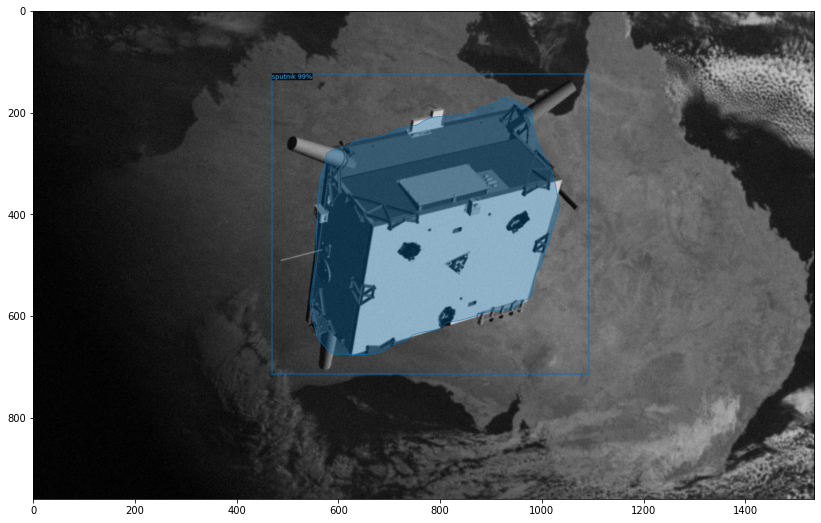

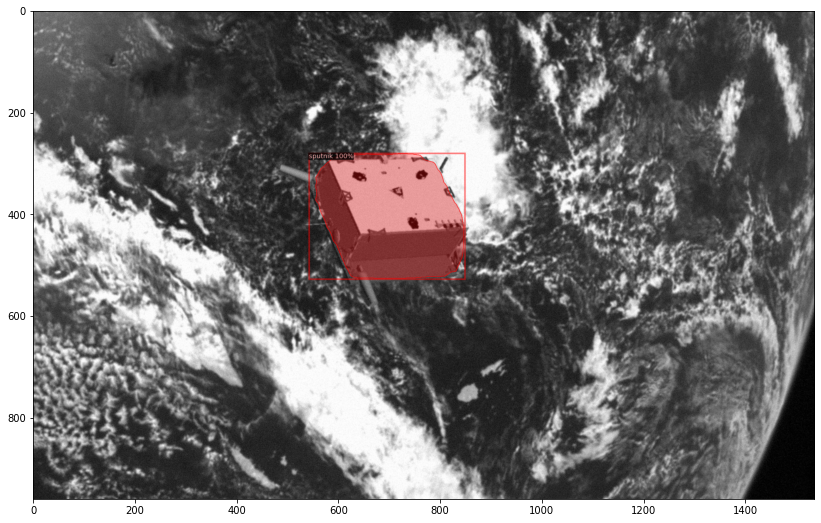

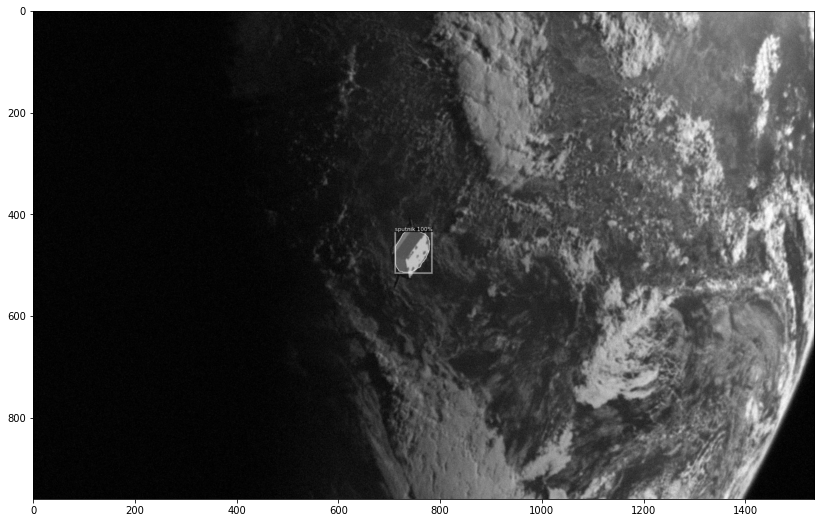

In [12]:
#8. Запуск нейросети. Это последний пункт в основной части, вся информация ниже создана чисто для отладки.
import os
import random
from detectron2.utils.visualizer import ColorMode

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.98 #Здесь мы можем указать нужную нам точность, т.к. я уверен в своей нейросети точность стоит 98 процентов.
cfg.DATASETS.TEST = ("sputnik_test")
cfg.MODEL.BACKBONE.FREEZE_AT = 0
predictor = DefaultPredictor(cfg)


for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sputnik_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

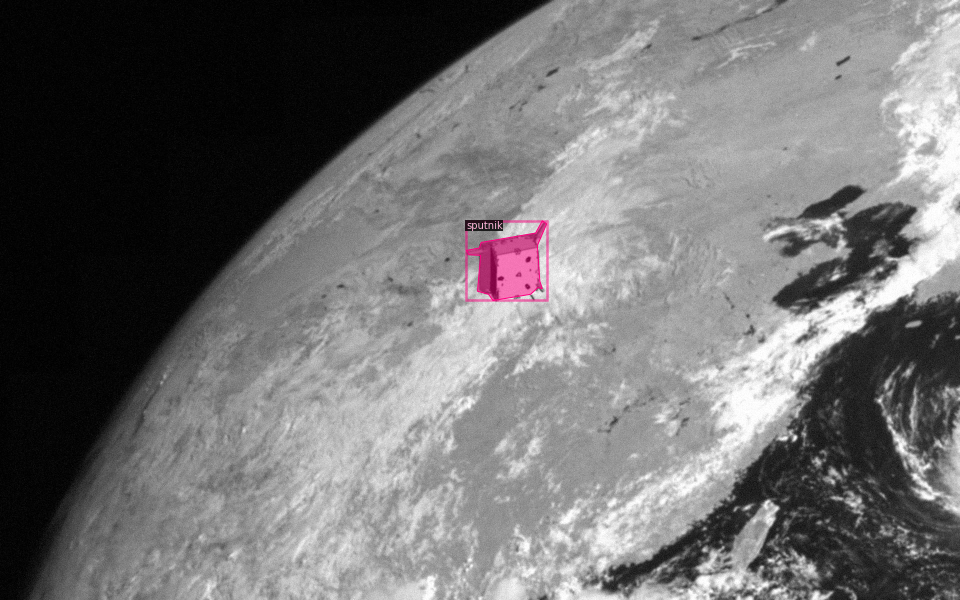

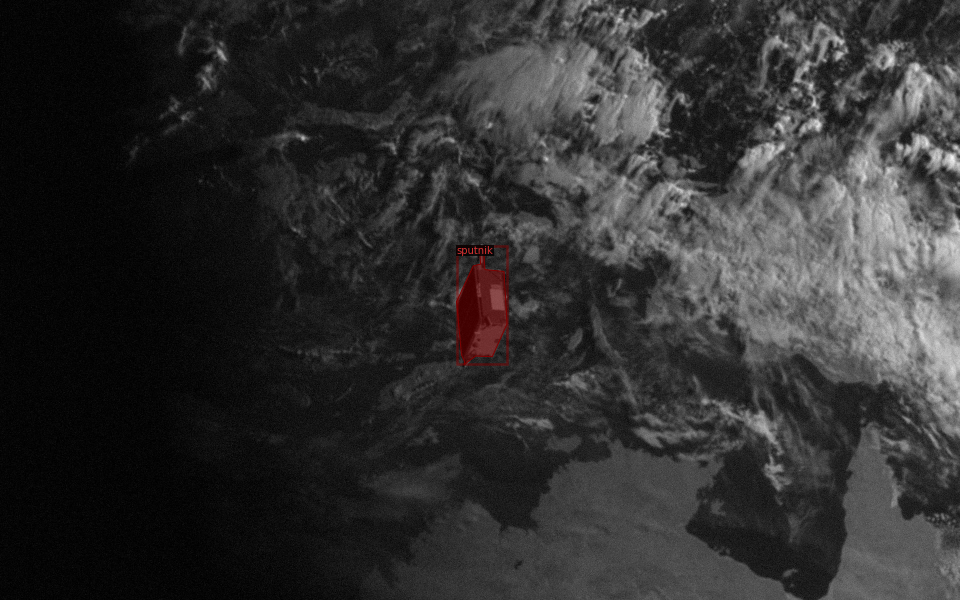

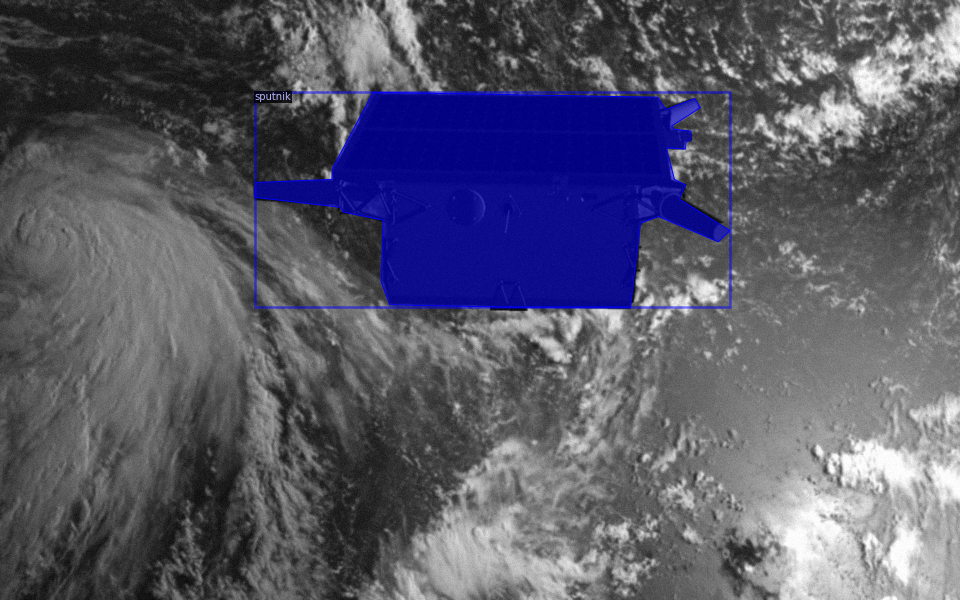

In [13]:
#9. Просмотр масок, с помощью которых была натренирована нейросеть.
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sputnik_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [14]:
#10. Проверка метадаты класса "спутники"
sputnik_metadata

Metadata(evaluator_type='coco', image_root='/content/traintrain', json_file='/content/train.json', name='sputniktrain', thing_classes=['sputnik'], thing_dataset_id_to_contiguous_id={0: 0})